# Visualising and operating on a transmission matrix

In [1]:
%pylab inline
%gui qt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipywidgets import interact

## First, create the visualisation tools that we'll need and a library to load images

In [3]:
import pyqtgraph as pg
from field_visualisation.field_visualisation import show_field

Could not import cv2. Will still work but slower


In [4]:
# create a viewer
imv = pg.ImageView(view=pg.PlotItem())
imv.show()

## These we'll need for analysis of the transmission matrix

In [5]:
from phyber_analyzer import transmission_matrix_preprocessing as tmp
from phyber_analyzer import transmission_matrix_operations as tmo

Loading...


In [6]:
from ipywidgets import interact

### Load input data

In [7]:
TM2 = np.load('./TM_big.npz')['TM']

In [8]:
# corresponds to a TM with 33x33 input pixels and 75x75 output pixels
print(TM2.shape)

(33, 33, 75, 75)


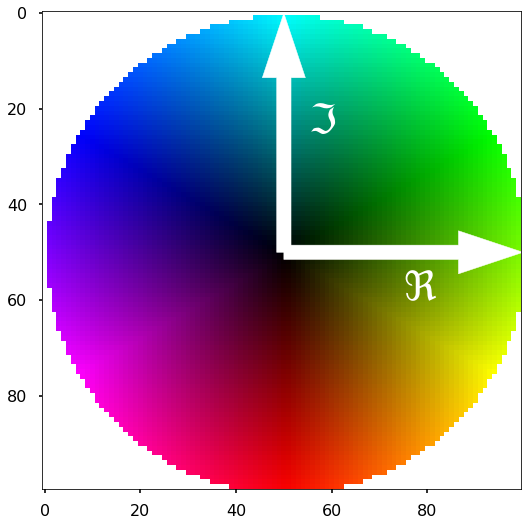

In [10]:
# show amplitude-phase picture
with matplotlib.style.context(['seaborn-poster', 'seaborn-colorblind']):
    yy, xx = np.mgrid[-50:50, -50:50] - 0.5
    rr = np.hypot(yy,xx)
    rr[rr>50] = None
    ph = np.angle(yy+1j*xx)
    field = rr * np.exp(1j*ph)
    
    show_field(field, ax=gca());
    arrow(50,50,50, 0, color='white', width=3, length_includes_head=True)
    annotate('$\Re$', xy=(75,60), fontsize=40, color='white')
    annotate('$\Im}$', xy=(55,25), fontsize=40, color='white')
    arrow(50,50,0, -50, color='white', width=3, length_includes_head=True)

In [11]:
# first, show the fields of the transmission matrix
ndist = TM2.shape[-1]
show_field(TM2.reshape(-1, ndist, ndist), imv)
pass

In [9]:
# There is still a clear tilt of the field corresponding to the angle between the distal camera and the reference

In [12]:
from ipywidgets import interact

In [13]:
@interact
def show_TM(idx_y=15, idx_x=15, show_farfield=False):
    field = TM2[idx_y, idx_x]
    if show_farfield:
        field = fftshift(fft2(ifftshift(field)))
    show_field(field, imv, ax=gca())

interactive(children=(IntSlider(value=15, description='idx_y', max=45, min=-15), IntSlider(value=15, descripti…

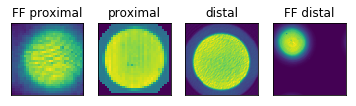

In [14]:
fig = figure()
tmp.plot_averaged_projections(TM2, fig)
for ax in fig.axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

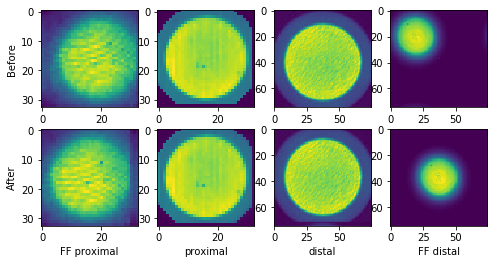

In [15]:
# Center the data of the transmission matrix


fig = figure(figsize=(8,4))
for ax in fig.axes:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
tight_layout()
TM_centered, misalignments = tmp.center_TM(TM2, figure=fig)

In [17]:
# clip the transmission matrix
av_proj = tmo.averaged_projection(TM_centered, location=3)
imv.setImage(av_proj)

In [18]:
# find the area that we will need
filter_mask = av_proj > 1000
imv.setImage(filter_mask)

In [19]:
from scipy import ndimage
sy, sx = ndimage.find_objects(filter_mask)[0]
print(TM_centered[0,0][sy, sx].shape)
imv.setImage(av_proj[sy, sx])

(49, 49)


In [20]:
TM_ff = tmo.TM_FFT(TM_centered)
# filter all the distal fields in-place
TM_ff *= filter_mask
# take out only the central part
TM_ff = TM_ff[:, :, sy, sx]
TM_ds = tmo.TM_FFT(TM_ff, inverse=True)
# center it once more for good measure
TM_ds, _ = tmp.center_TM(TM_ds)

## Check that the results make sense

In [22]:
@interact
def show_TM(idx_y=15, idx_x=15, show_farfield=False, show_original=False):
    
    field = TM_ds[idx_y, idx_x]
    if show_original:
        field = TM_centered[idx_y, idx_x]
    if show_farfield:
        field = fftshift(fft2(ifftshift(field)))
    show_field(field, imv, ax=gca())

interactive(children=(IntSlider(value=15, description='idx_y', max=45, min=-15), IntSlider(value=15, descripti…

## Optional: center in a different way by analyzing symmetry of the farfield

In [23]:
# analyze symmetry
def TM_symmetry(TM):
    TM_I = TM
    # norm all of them
    TM_I /= np.linalg.norm(TM_I, axis=(-2,-1))[:,:,None,None] + 0.01
    TM_flipped = TM_I[:,:,::-1,::-1]
    TM_flipped2 = TM_I[...,::-1,:]
    TM_flipped3 = TM_I[...,::-1]
    difference = 3*TM_I-TM_flipped-TM_flipped2-TM_flipped3
    imv.setImage(abs(difference).reshape(-1,75,75))
    pg.QtGui.QApplication.processEvents()
    return 0.25*np.linalg.norm(difference, axis=(-2,-1))
symmetry_score = TM_symmetry(TM_centered)

In [127]:
FF_TM = tmo.TM_FFT(TM_centered, side=0)
FF_TM.shape = 33**2, 75**2

In [171]:
def symmetry(shifts, FF_TM=FF_TM):
    nd = int(np.sqrt(FF_TM.shape[0]))
    nprox = int(np.sqrt(FF_TM.shape[1]))
    centered_image = np.ones((nd, nd))
    centered_image = fftshift(ndimage.fourier_shift(centered_image, shifts))
    centered_image.shape = nd*nd
    output_field = np.reshape(centered_image@FF_TM, [nprox, nprox])
    show_field(output_field, imv)
    pg.QtGui.QApplication.processEvents()
    output_field /= np.linalg.norm(output_field)
    return analyze_symmetry(output_field)

def analyze_symmetry(field):
    
    field_flipped = field[::-1,::-1]
    field_ud = np.flipud(field)
    field_lr = np.fliplr(field)
    return 1./4*np.linalg.norm(3*field - field_flipped - field_ud - field_lr)

In [147]:
from scipy.optimize import fmin

In [156]:
FF_TM_FF = tmo.TM_FFT(FF_TM, side=1)

In [173]:
fmin(lambda x: symmetry(x, FF_TM=FF_TM_FF.T), [0,.2])

Optimization terminated successfully.
         Current function value: 0.504244
         Iterations: 50
         Function evaluations: 94


array([-0.12,  0.05])

In [174]:
fmin(lambda x: symmetry(x, FF_TM=FF_TM_FF), [0,.2])

Optimization terminated successfully.
         Current function value: 0.375676
         Iterations: 45
         Function evaluations: 87


array([ 0.04, -0.01])

In [138]:
symmetry([0,0])

631.0369042435656

In [102]:
imv.setImage(symmetry_score)

In [77]:
show_field(TM_centered.reshape(-1,75,75), imv)

array([[[[0.  , 0.05, 0.04],
         [0.  , 0.01, 0.03],
         [0.04, 0.  , 0.05],
         ...,
         [0.04, 0.04, 0.  ],
         [0.05, 0.05, 0.  ],
         [0.04, 0.01, 0.  ]],

        [[0.  , 0.03, 0.05],
         [0.01, 0.  , 0.04],
         [0.05, 0.  , 0.02],
         ...,
         [0.  , 0.01, 0.  ],
         [0.02, 0.02, 0.  ],
         [0.04, 0.02, 0.  ]],

        [[0.  , 0.  , 0.04],
         [0.02, 0.  , 0.01],
         [0.06, 0.02, 0.  ],
         ...,
         [0.  , 0.03, 0.06],
         [0.  , 0.04, 0.05],
         [0.  , 0.01, 0.  ]],

        ...,

        [[0.02, 0.  , 0.02],
         [0.05, 0.  , 0.01],
         [0.05, 0.  , 0.05],
         ...,
         [0.  , 0.01, 0.04],
         [0.  , 0.03, 0.02],
         [0.03, 0.03, 0.  ]],

        [[0.  , 0.04, 0.  ],
         [0.01, 0.02, 0.  ],
         [0.01, 0.  , 0.01],
         ...,
         [0.  , 0.05, 0.04],
         [0.  , 0.05, 0.01],
         [0.05, 0.06, 0.  ]],

        [[0.02, 0.04, 0.  ],
       

In [69]:
phase_exp = fftshift(ndimage.fourier.fourier_shift(np.ones((75,75)), [16.68,17.81]))

In [71]:
TM_fields *= phase_exp

In [72]:
show_field(TM_fields.reshape(-1,75,75), imv)

array([[[[0.  , 0.05, 0.04],
         [0.  , 0.01, 0.03],
         [0.04, 0.  , 0.05],
         ...,
         [0.04, 0.04, 0.  ],
         [0.05, 0.05, 0.  ],
         [0.04, 0.01, 0.  ]],

        [[0.  , 0.03, 0.05],
         [0.01, 0.  , 0.04],
         [0.05, 0.  , 0.02],
         ...,
         [0.  , 0.01, 0.  ],
         [0.02, 0.02, 0.  ],
         [0.04, 0.02, 0.  ]],

        [[0.  , 0.  , 0.04],
         [0.02, 0.  , 0.01],
         [0.06, 0.02, 0.  ],
         ...,
         [0.  , 0.03, 0.06],
         [0.  , 0.04, 0.05],
         [0.  , 0.01, 0.  ]],

        ...,

        [[0.02, 0.  , 0.02],
         [0.05, 0.  , 0.01],
         [0.05, 0.  , 0.05],
         ...,
         [0.  , 0.01, 0.04],
         [0.  , 0.03, 0.02],
         [0.03, 0.03, 0.  ]],

        [[0.  , 0.04, 0.  ],
         [0.01, 0.02, 0.  ],
         [0.01, 0.  , 0.01],
         ...,
         [0.  , 0.05, 0.04],
         [0.  , 0.05, 0.01],
         [0.05, 0.06, 0.  ]],

        [[0.02, 0.04, 0.  ],
       

In [58]:
TM_centered,center_pos = tmp.center_TM(TM_padded, locations=[3,])

In [59]:
center_pos

array([[16.68, 17.81],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ]])

In [19]:
show_field(TM_centered.reshape(31*31,75,75), imv)
pass

array([[[[0.  , 0.05, 0.04],
         [0.  , 0.03, 0.05],
         [0.  , 0.  , 0.04],
         ...,
         [0.02, 0.  , 0.02],
         [0.  , 0.04, 0.  ],
         [0.02, 0.04, 0.  ]],

        [[0.  , 0.01, 0.03],
         [0.01, 0.  , 0.04],
         [0.02, 0.  , 0.01],
         ...,
         [0.05, 0.  , 0.01],
         [0.01, 0.02, 0.  ],
         [0.03, 0.05, 0.  ]],

        [[0.04, 0.  , 0.05],
         [0.05, 0.  , 0.02],
         [0.06, 0.02, 0.  ],
         ...,
         [0.05, 0.  , 0.05],
         [0.01, 0.  , 0.01],
         [0.  , 0.04, 0.01]],

        ...,

        [[0.04, 0.04, 0.  ],
         [0.  , 0.01, 0.  ],
         [0.  , 0.03, 0.06],
         ...,
         [0.  , 0.01, 0.04],
         [0.  , 0.05, 0.04],
         [0.  , 0.06, 0.03]],

        [[0.05, 0.05, 0.  ],
         [0.02, 0.02, 0.  ],
         [0.  , 0.04, 0.05],
         ...,
         [0.  , 0.03, 0.02],
         [0.  , 0.05, 0.01],
         [0.05, 0.07, 0.  ]],

        [[0.04, 0.01, 0.  ],
       